In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-risk/financial_risk_assessment.csv


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
df = pd.read_csv("/kaggle/input/financial-risk/financial_risk_assessment.csv")
print(df.head(3))
print("The dataset has {} observations and {} variables".format(df.shape[0], df.shape[1]))
print("Information about the data", df.info())

   Age      Gender Education Level Marital Status   Income  Credit Score  \
0   49        Male             PhD       Divorced  72799.0         688.0   
1   57      Female      Bachelor's        Widowed      NaN         690.0   
2   21  Non-binary        Master's         Single  55687.0         600.0   

   Loan Amount Loan Purpose Employment Status  Years at Current Job  \
0      45713.0     Business        Unemployed                    19   
1      33835.0         Auto          Employed                     6   
2      36623.0         Home          Employed                     8   

  Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0            Poor              0.154313      120228.0                   0.0   
1            Fair              0.148920       55849.0                   0.0   
2            Fair              0.362398      180700.0                   3.0   

              City State       Country  Previous Defaults  \
0   Port Elizabeth    AS        

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
from ydata_profiling import ProfileReport
from IPython.display import FileLink

profile = ProfileReport(df, title="EDA for Dataset", explorative=True, progress_bar=True)
profile.to_file("EDA_Report_first.html")

# Show link to download
FileLink("EDA_Report_first.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/working/EDA_Report_first.html

# Data Cleaning

## Handling Missing Values

In [4]:
# Rank variables with the highest percentage of missing data first
df_missing = df.isnull().sum().sort_values(ascending=False) / len(df) * 100
print("\nRanking Missing values (%):\n", df_missing)


Ranking Missing values (%):
 Assets Value             15.0
Previous Defaults        15.0
Income                   15.0
Credit Score             15.0
Loan Amount              15.0
Number of Dependents     15.0
Age                       0.0
Marital Status Change     0.0
Country                   0.0
State                     0.0
City                      0.0
Payment History           0.0
Debt-to-Income Ratio      0.0
Gender                    0.0
Years at Current Job      0.0
Employment Status         0.0
Loan Purpose              0.0
Marital Status            0.0
Education Level           0.0
Risk Rating               0.0
dtype: float64


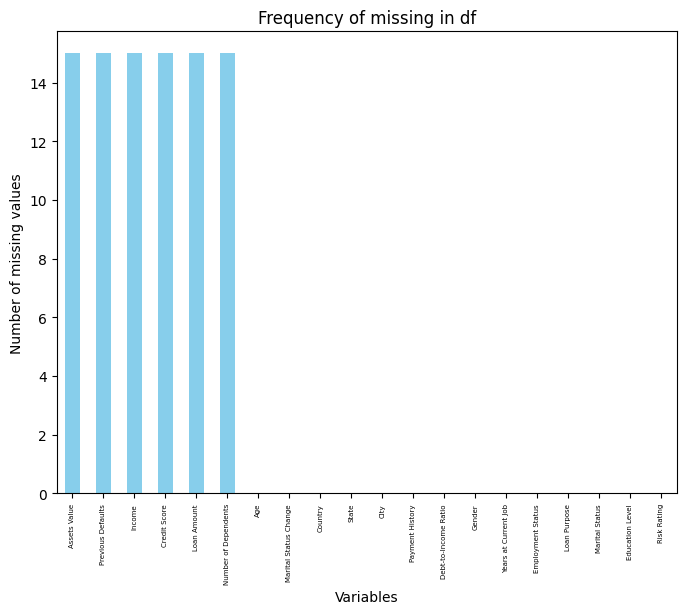

<Axes: >

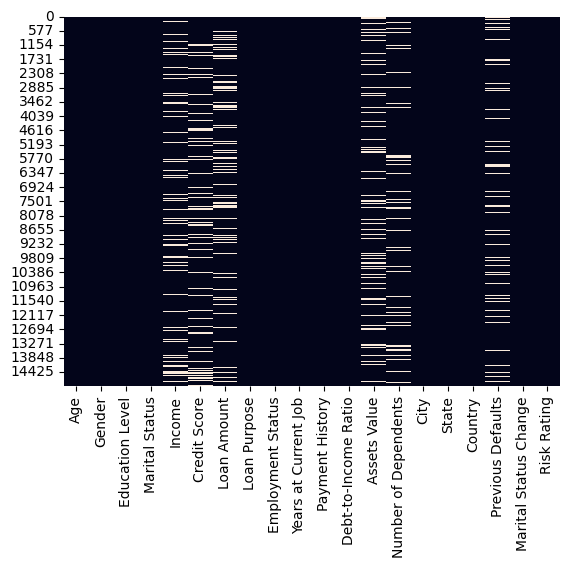

In [5]:

## Identifying Missing values: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot
plt.figure(figsize=(8, 6))
df_missing.plot(kind='bar', color='skyblue')
plt.title('Frequency of missing in df')
plt.xlabel('Variables')
plt.ylabel('Number of missing values')
plt.xticks(rotation=90, size=5)
plt.show()

# Using seaborn package
sns.heatmap(df.isnull(), cbar=False)

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

# Encode categorical variables
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

Var_MV = ['Income', 'Credit Score', 'Loan Amount', 'Assets Value', 'Number of Dependents', 'Previous Defaults']

for col in Var_MV:
    # Create missing flag
    missing_flag = df_encoded[col].isnull().astype(int)

    # Prepare features and target
    X = df_encoded.drop(columns=[col]).fillna(df_encoded.select_dtypes(include='number').mean())
    y = missing_flag

    # Train logistic regression and compute AUC
    model = LogisticRegression(max_iter=500)
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()

    # Interpret AUC
    if auc >= 0.6:
        print(f"AUC score for predicting missingness in {col}: {auc:.3f}. Therefore, the missingness in {col} is likely **not MCAR**.")
    else:
        print(f"AUC score for predicting missingness in {col}: {auc:.3f}. Therefore, the missingness in {col} is likely **MCAR**.")


AUC score for predicting missingness in Income: 0.493. Therefore, the missingness in Income is likely **MCAR**.
AUC score for predicting missingness in Credit Score: 0.503. Therefore, the missingness in Credit Score is likely **MCAR**.
AUC score for predicting missingness in Loan Amount: 0.500. Therefore, the missingness in Loan Amount is likely **MCAR**.
AUC score for predicting missingness in Assets Value: 0.508. Therefore, the missingness in Assets Value is likely **MCAR**.
AUC score for predicting missingness in Number of Dependents: 0.499. Therefore, the missingness in Number of Dependents is likely **MCAR**.
AUC score for predicting missingness in Previous Defaults: 0.507. Therefore, the missingness in Previous Defaults is likely **MCAR**.


In [7]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

cols = ['Income', 'Credit Score', 'Loan Amount', 'Assets Value', 'Number of Dependents', 'Previous Defaults']

scaler = StandardScaler()
imputer = KNNImputer(
    missing_values=np.nan,
    n_neighbors=7,
    weights="distance",
    metric="nan_euclidean",
    copy=True,
    add_indicator=True
)

X = df[cols].to_numpy()
Xz = scaler.fit_transform(X)
Xz_imp = imputer.fit_transform(Xz)

# Separate imputed values and indicators
Xz_imp_values = Xz_imp[:, :len(cols)]  # first 6 columns
Xz_imp_indicators = Xz_imp[:, len(cols):]  # last 6 columns

# Inverse transform only the scaled values
X_imp = scaler.inverse_transform(Xz_imp_values)

# Reconstruct the DataFrame
df_imputed = df.copy()
df_imputed[cols] = X_imp

# Optionally add indicator columns
for i, col in enumerate(cols):
    df_imputed[f"{col}_missing"] = Xz_imp_indicators[:, i]

print(df_imputed.head(3))


   Age      Gender Education Level Marital Status        Income  Credit Score  \
0   49        Male             PhD       Divorced  72799.000000         688.0   
1   57      Female      Bachelor's        Widowed  51051.470456         690.0   
2   21  Non-binary        Master's         Single  55687.000000         600.0   

   Loan Amount Loan Purpose Employment Status  Years at Current Job  ...  \
0      45713.0     Business        Unemployed                    19  ...   
1      33835.0         Auto          Employed                     6  ...   
2      36623.0         Home          Employed                     8  ...   

        Country  Previous Defaults  Marital Status Change  Risk Rating  \
0        Cyprus                2.0                      2          Low   
1  Turkmenistan                3.0                      2       Medium   
2    Luxembourg                3.0                      2       Medium   

  Income_missing Credit Score_missing Loan Amount_missing  \
0           

In [8]:
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           15000 non-null  int64  
 1   Gender                        15000 non-null  object 
 2   Education Level               15000 non-null  object 
 3   Marital Status                15000 non-null  object 
 4   Income                        15000 non-null  float64
 5   Credit Score                  15000 non-null  float64
 6   Loan Amount                   15000 non-null  float64
 7   Loan Purpose                  15000 non-null  object 
 8   Employment Status             15000 non-null  object 
 9   Years at Current Job          15000 non-null  int64  
 10  Payment History               15000 non-null  object 
 11  Debt-to-Income Ratio          15000 non-null  float64
 12  Assets Value                  15000 non-null  float64
 13  N

## Checking and handling Outliers

In [9]:
new_data = df_imputed.iloc[:, 0:20].copy()

numeric_df = new_data.select_dtypes(include = 'number')

numeric_df.describe()

,Age,Income,Credit Score,Loan Amount,Years at Current Job,Debt-to-Income Ratio,Assets Value,Number of Dependents,Previous Defaults,Marital Status Change
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,43.452667,69692.378501,699.419922,27306.429079,9.476267,0.350438,158117.706920,2.020097,2.001518,0.998467
std,14.910732,27670.896422,54.458760,12279.533546,5.769707,0.143919,76668.498562,1.357592,1.345083,0.813782
min,18.000000,20005.000000,600.000000,5000.000000,0.000000,0.100004,20055.000000,0.000000,0.000000,0.000000
25%,31.000000,46789.500000,655.857143,17509.000000,4.000000,0.227386,97748.500000,1.000000,1.000000,0.000000
50%,43.000000,69426.000000,699.000000,27120.500000,9.000000,0.350754,154418.071429,2.000000,2.000000,1.000000
75%,56.000000,92564.500000,743.000000,37028.250000,15.000000,0.476095,219448.000000,3.000000,3.000000,2.000000
max,69.000000,119997.000000,799.000000,49998.000000,19.000000,0.599970,299999.000000,4.000000,4.000000,2.000000


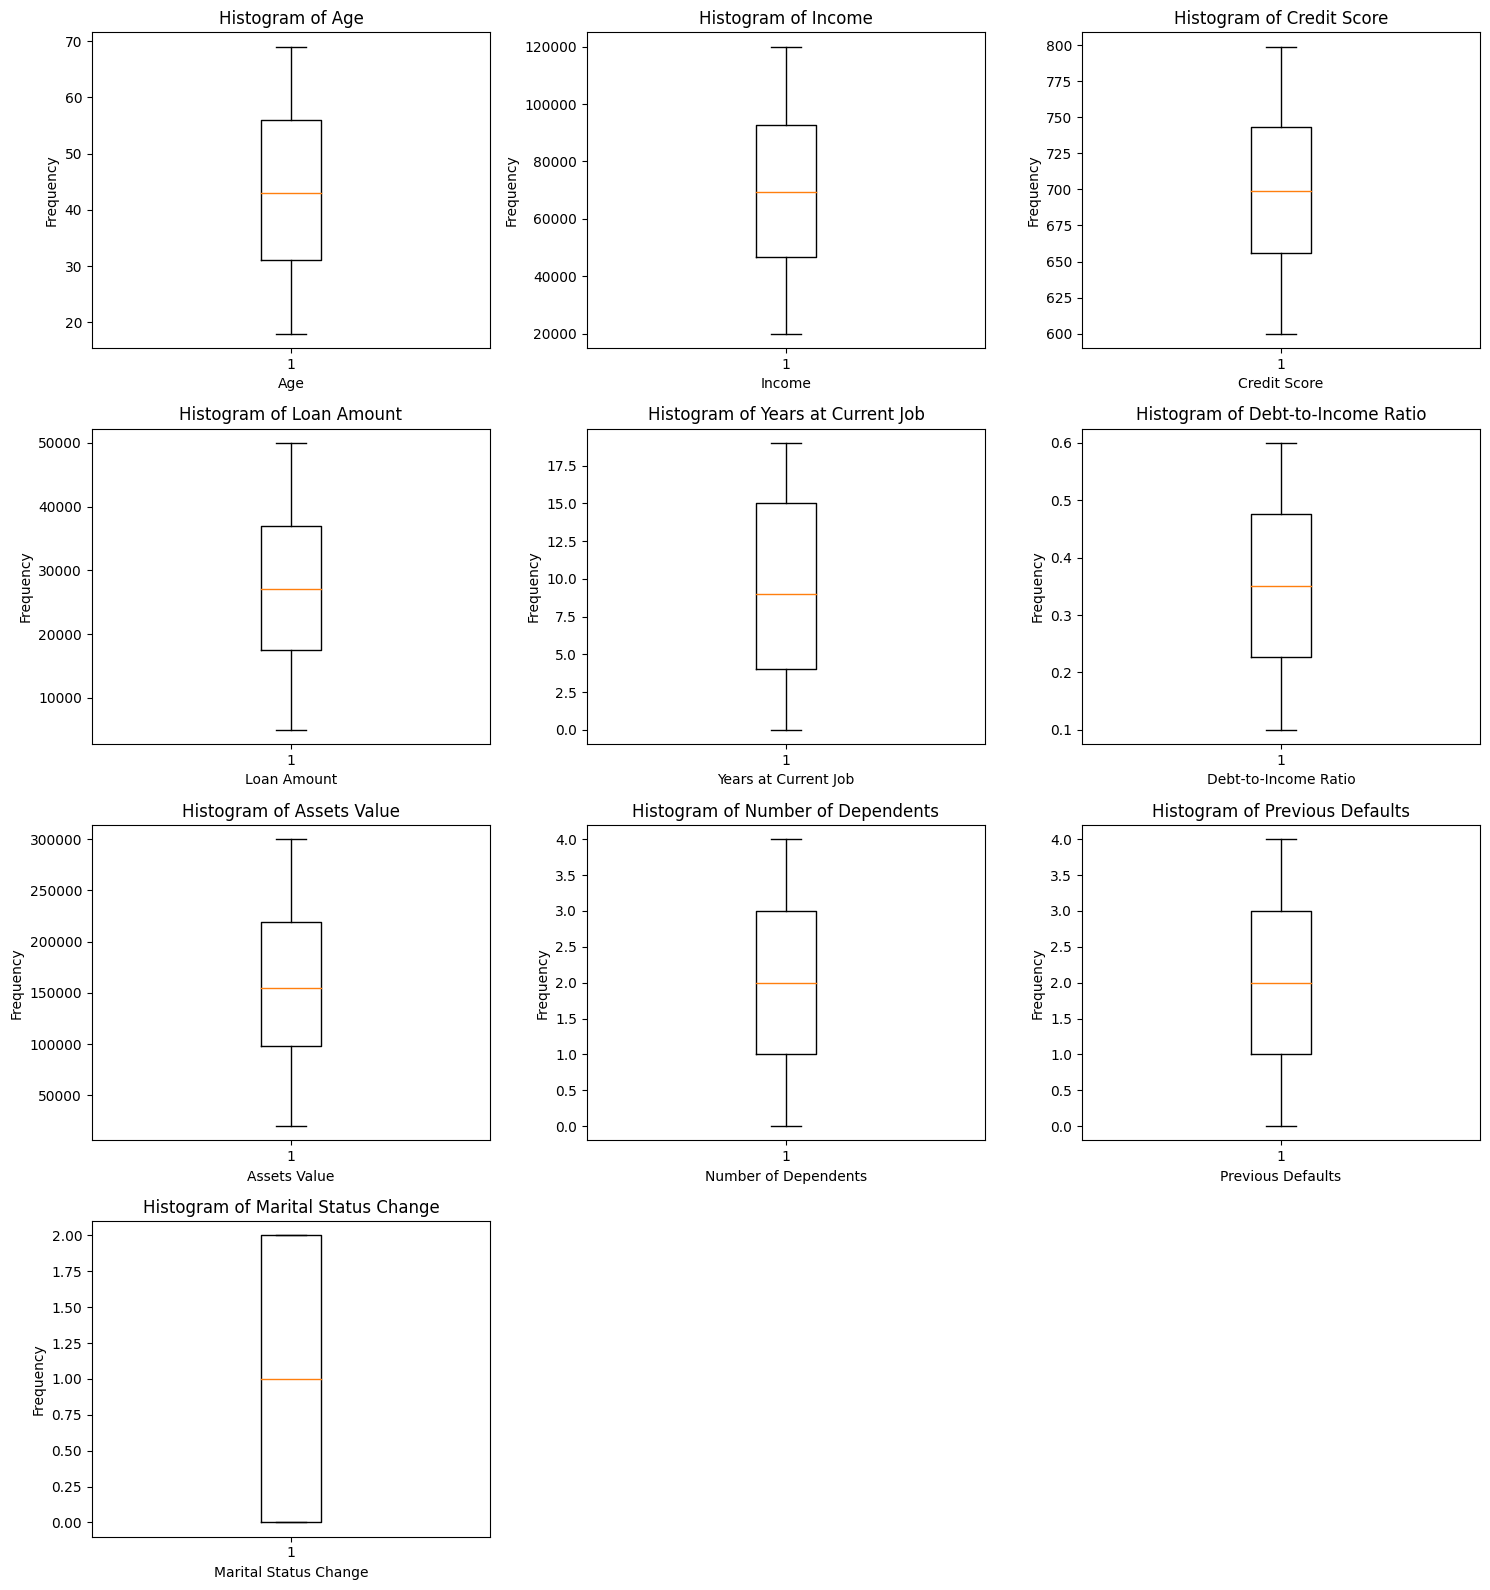

In [10]:
num_cols = len(numeric_df.columns)
n_cols = num_cols // 3  # number of columns in plot grid
n_rows = (num_cols + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(numeric_df[col].dropna())
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The visualization using the boxplot shows that the numeric variables in the dataset have no outliers.

In [11]:
cat_df = new_data.select_dtypes(include = 'object')
num_cols = len(cat_df.columns)
print(num_cols)

10


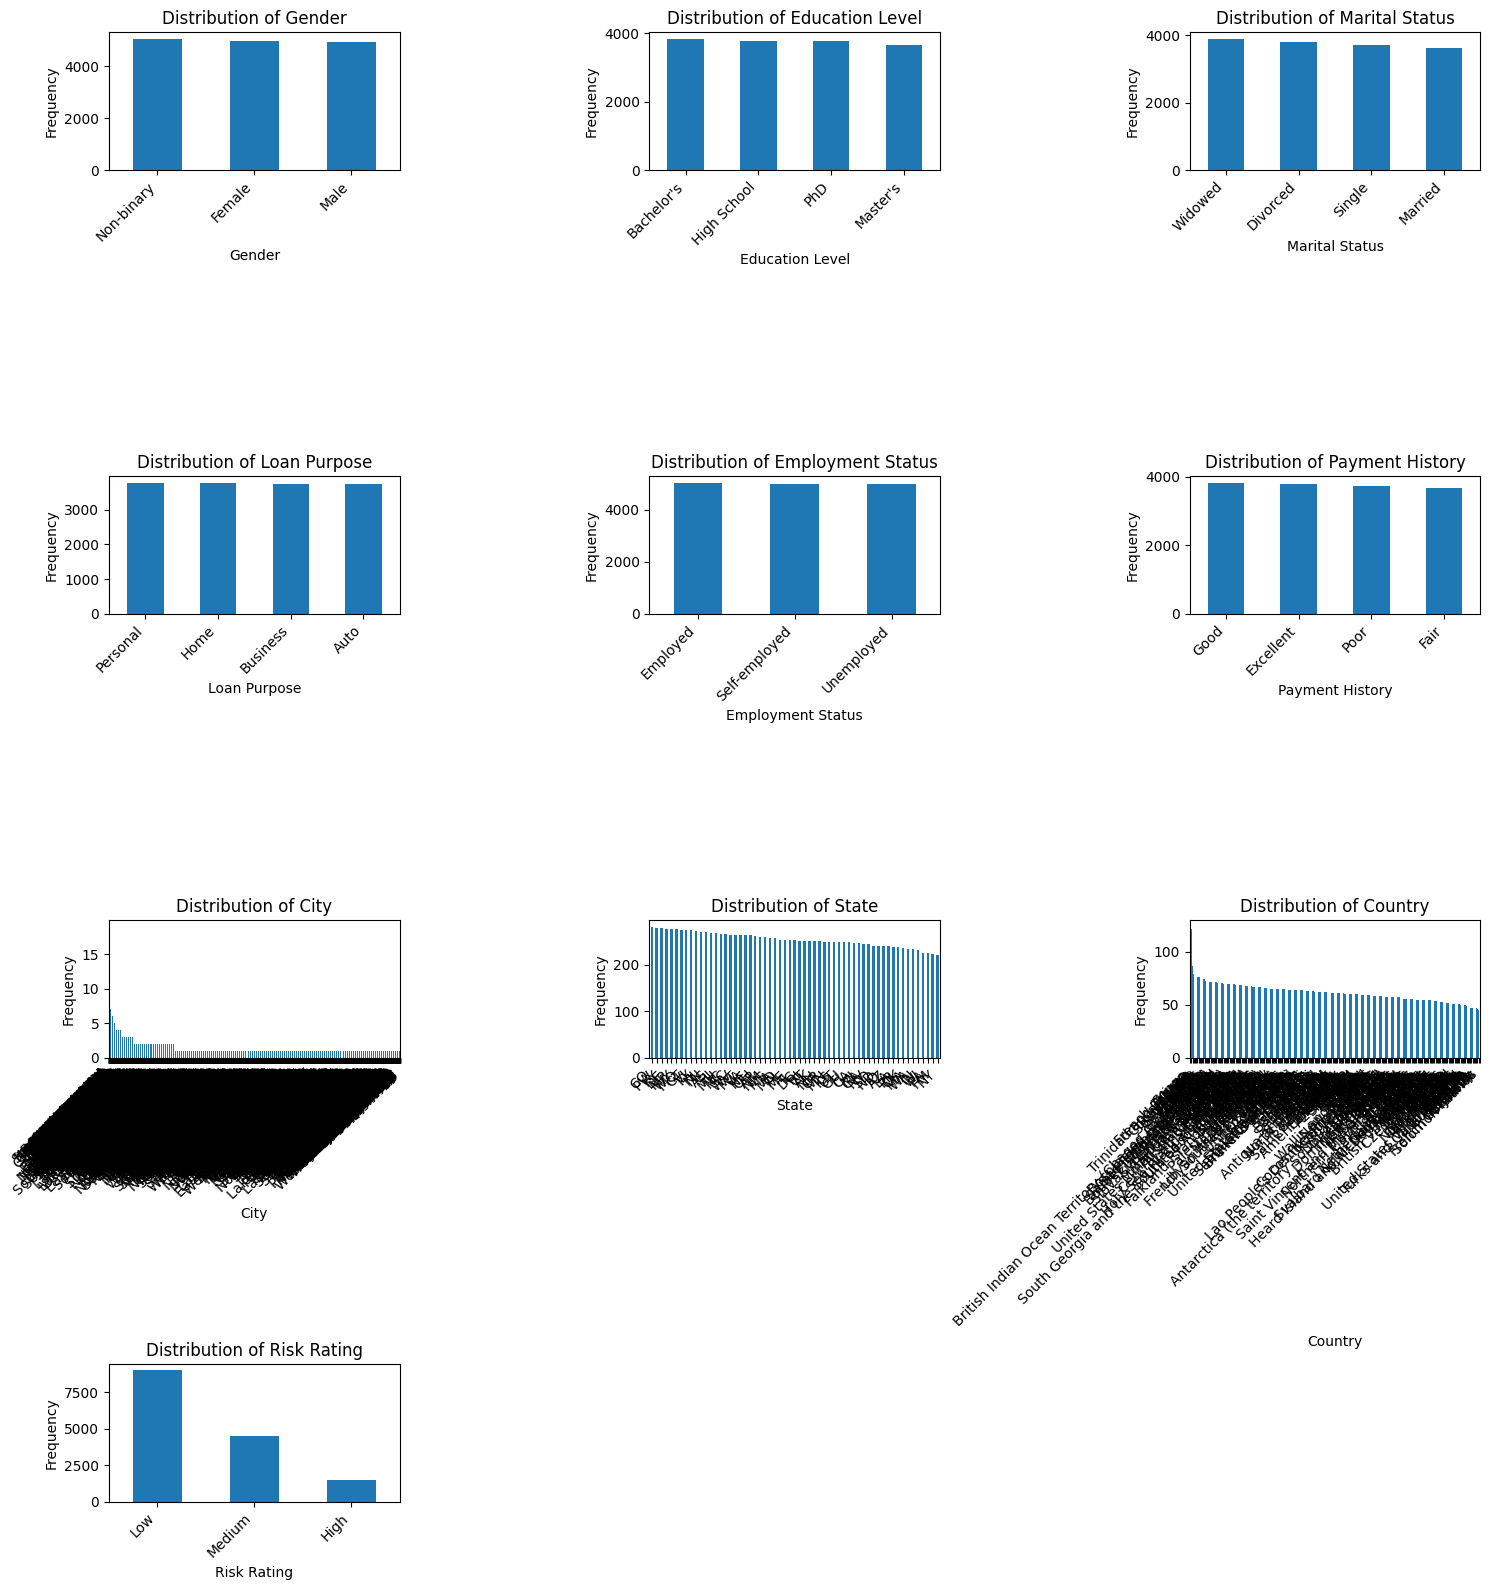

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Select categorical columns
cat_df = new_data.select_dtypes(include='object')
num_cols = len(cat_df.columns)

# Define subplot grid size
n_cols = 3  # Number of columns per row (adjustable)
n_rows = math.ceil(num_cols / n_cols)  # Rows needed

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Loop through columns to plot
for i, col in enumerate(cat_df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    value_counts = cat_df[col].value_counts()
    value_counts.plot(kind='bar')  # Create bar chart
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability

plt.tight_layout()
plt.show()


# Bivariate Analysis

## Correlation Analysis

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


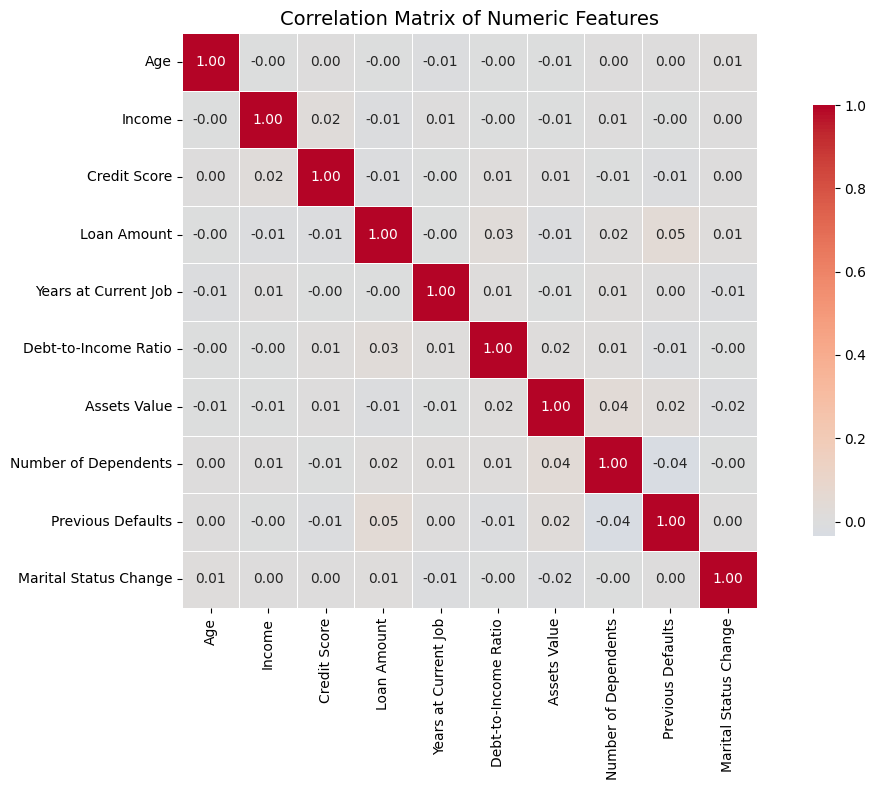

In [13]:
import seaborn as sns
# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set plot size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix,
    annot=True,            # show correlation coefficients
    fmt=".2f",             # format the numbers
    cmap="coolwarm",       # color scheme
    center=0,              # center the colormap at 0
    square=True,           # make each cell square
    linewidths=0.5,        # lines between cells
    cbar_kws={"shrink": 0.75}  # colorbar size
)

# Add title
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

## Chi-Square Analysis: Test of Association

In [14]:
import pandas as pd
from scipy.stats import chi2_contingency
from itertools import combinations

# Select the categorical columns
cat_cols = ['Gender', 'Marital Status', 'Loan Purpose', 'Education Level',
            'Employment Status', 'Payment History','Risk Rating']

# Perform chi-square test for all pairwise combinations
results = []
for col1, col2 in combinations(cat_cols, 2):
    contingency_table = pd.crosstab(cat_df[col1], cat_df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Variable 1': col1,
        'Variable 2': col2,
        'Chi2 Statistic': round(chi2, 3),
        'p-value': round(p, 4),
        'Degrees of Freedom': dof
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Chi-square test results for all pairwise combinations of categorical variables:")
print(results_df)


Chi-square test results for all pairwise combinations of categorical variables:
           Variable 1         Variable 2  Chi2 Statistic  p-value  \
0              Gender     Marital Status           3.660   0.7226   
1              Gender       Loan Purpose           1.892   0.9294   
2              Gender    Education Level           9.020   0.1725   
3              Gender  Employment Status           1.959   0.7432   
4              Gender    Payment History           5.541   0.4765   
5              Gender        Risk Rating           7.678   0.1041   
6      Marital Status       Loan Purpose           5.691   0.7704   
7      Marital Status    Education Level           5.598   0.7794   
8      Marital Status  Employment Status           2.525   0.8657   
9      Marital Status    Payment History          10.769   0.2919   
10     Marital Status        Risk Rating           5.576   0.4724   
11       Loan Purpose    Education Level          10.579   0.3057   
12       Loan Purpose  

# Geographical Analysis

In [15]:
import plotly.io as pio
import plotly.express as px

fig = px.choropleth(
    new_data,
    locations="Country",
    locationmode="country names",
    color="Income",
    color_continuous_scale="Viridis",
    title="Income Distribution Across Countries"
)
from IPython.display import IFrame
fig.write_html("income_map.html", include_plotlyjs="cdn")
IFrame("income_map.html", width=900, height=600)


In [16]:
import plotly.io as pio
import plotly.express as px

fig = px.choropleth(
    new_data,
    locations="Country",
    locationmode="country names",
    color="Risk Rating",
    color_continuous_scale="Viridis",
    title="Income Distribution Across Countries"
)
from IPython.display import IFrame
fig.write_html("income_map.html", include_plotlyjs="cdn")
IFrame("income_map.html", width=900, height=600)


# Distribution of Financial Risk taken

# Modelling and Prediction

In [17]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

new_data_process = new_data.copy()
new_data_process = new_data_process.drop(columns=['City', 'State'])

numeric_col = new_data_process.select_dtypes(include='number').columns.tolist()

#cat_cols_up = ['Gender', 'Marital Status', 'Loan Purpose', 'Education Level',
#            'Employment Status', 'Payment History', 'Risk Rating', 'Country']

cat_cols_up = new_data_process.select_dtypes(include='object').columns.tolist()
### Encoding Categorical Variable
label_encoders = {}
for col in cat_cols_up:
    le = LabelEncoder()
    new_data_process[col] = le.fit_transform(new_data_process[col].astype(str))
    label_encoders[col] = le

# Scale numeric variables
#scaler = MinMaxScaler()
scaler = StandardScaler()
new_data_process[numeric_col] = scaler.fit_transform(new_data_process[numeric_col])

print(new_data_process.head(2))

        Age  Gender  Education Level  Marital Status    Income  Credit Score  \
0  0.372049       1                3               0  0.112274     -0.209706   
1  0.908593       0                0               3 -0.673687     -0.172979   

   Loan Amount  Loan Purpose  Employment Status  Years at Current Job  \
0     1.499013             1                  2              1.650699   
1     0.531681             0                  0             -0.602523   

   Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0                3             -1.362787     -0.494218              -1.48805   
1                1             -1.400265     -1.333952              -1.48805   

   Country  Previous Defaults  Marital Status Change  Risk Rating  
0       55          -0.001129               1.230755            1  
1      223           0.742344               1.230755            2  


## Unsupervised Learning: K-Prototypes techniques

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



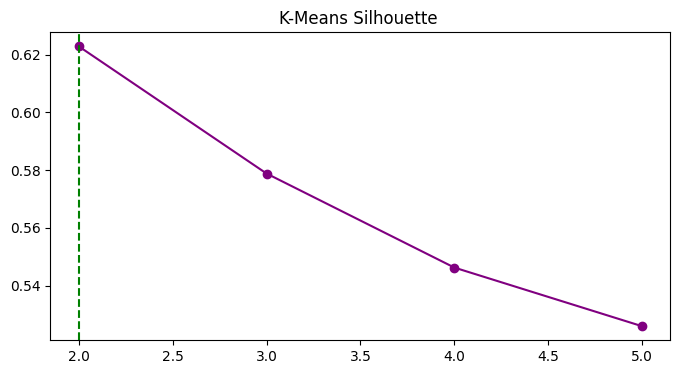

In [18]:
#!pip install kmodes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, min(6, len(new_data_process)))

for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', random_state=142)
    clusters = km.fit_predict(new_data_process)
    
    silhouette_scores.append(silhouette_score(new_data_process, clusters))

optimal_k = k_range[np.argmax(silhouette_scores)]

plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o', color='purple')
plt.axvline(optimal_k, color='green', linestyle='--')
plt.title("K-Means Silhouette ")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



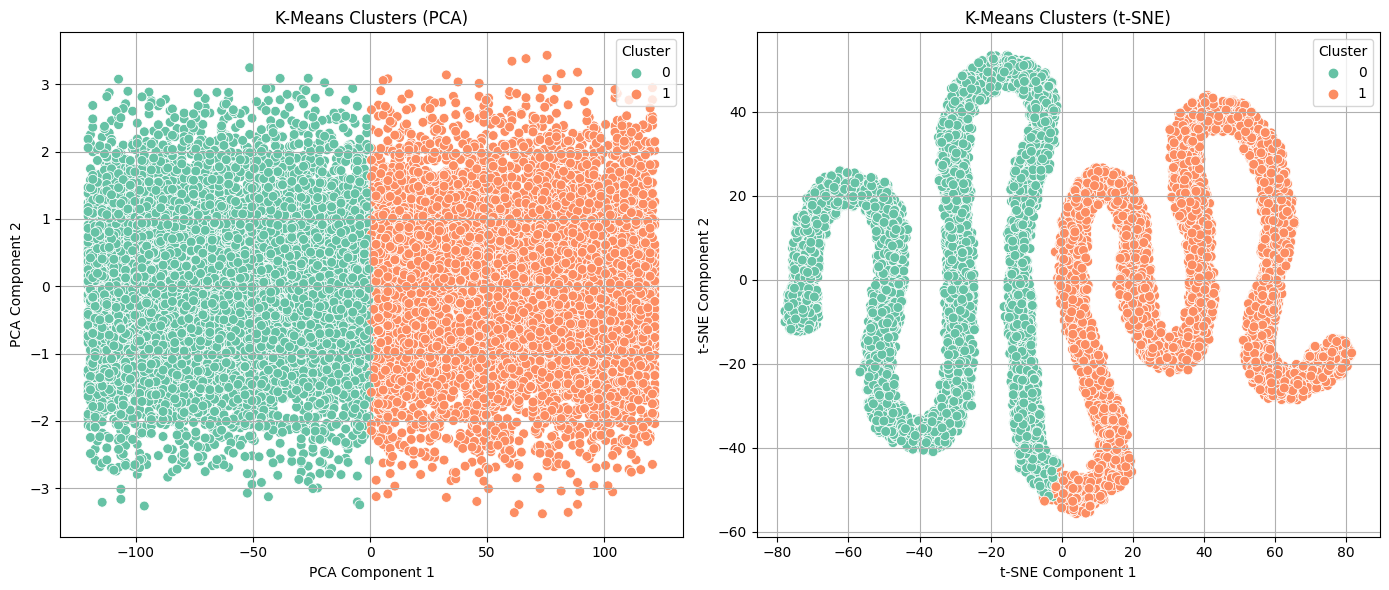

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

k = 2  # or any other number of clusters you'd like to use
km = KMeans(n_clusters=k, init='k-means++', random_state=142)
km_labels = km.fit_predict(new_data_process)

# ---- Dimension Reduction: PCA ----
pca = PCA(n_components=2, random_state=142)
pca_xy = pca.fit_transform(new_data_process)

# ---- Dimension Reduction: t-SNE ----
n_samples = len(new_data_process)
perp = min(30, max(5, n_samples // 4))
tsne = TSNE(n_components=2, perplexity=perp, n_iter=800, random_state=142,
            learning_rate='auto', init='pca')
tsne_xy = tsne.fit_transform(new_data_process)

# Mapping of embeddings
emb_map = {"PCA": pca_xy, "t-SNE": tsne_xy}

# ---- Plotting Results ----
plt.figure(figsize=(14, 6))

for i, (name, emb) in enumerate(emb_map.items()):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=km_labels, palette='Set2', s=50)
    plt.title(f"K-Means Clusters ({name})")
    plt.xlabel(f"{name} Component 1")
    plt.ylabel(f"{name} Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)

plt.tight_layout()
plt.show()


## Supervised Learning: Classification Method: Logistics Regression and Random Forest Model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier  # For classification tasks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [21]:
X = new_data_process.drop('Risk Rating', axis = 1)
y = new_data_process['Risk Rating']
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

In [22]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict(X_test)
preds_train = model_lr.predict(X_train)
print("Logistic Regression:")
print(confusion_matrix(y_test, preds_lr))
print(classification_report(y_test, preds_lr))
print("Accuracy :", accuracy_score(y_test, preds_lr))

Logistic Regression:
[[   0  293    0]
 [   0 1791    0]
 [   0  916    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.60      1.00      0.75      1791
           2       0.00      0.00      0.00       916

    accuracy                           0.60      3000
   macro avg       0.20      0.33      0.25      3000
weighted avg       0.36      0.60      0.45      3000

Accuracy : 0.597


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/l

In [23]:
model_rf = RandomForestClassifier(n_estimators=5, random_state=142, class_weight='balanced')
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
y_train_pred = model_rf.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5323333333333333
[[  23  218   52]
 [  76 1428  287]
 [  65  705  146]]
              precision    recall  f1-score   support

           0       0.14      0.08      0.10       293
           1       0.61      0.80      0.69      1791
           2       0.30      0.16      0.21       916

    accuracy                           0.53      3000
   macro avg       0.35      0.35      0.33      3000
weighted avg       0.47      0.53      0.49      3000



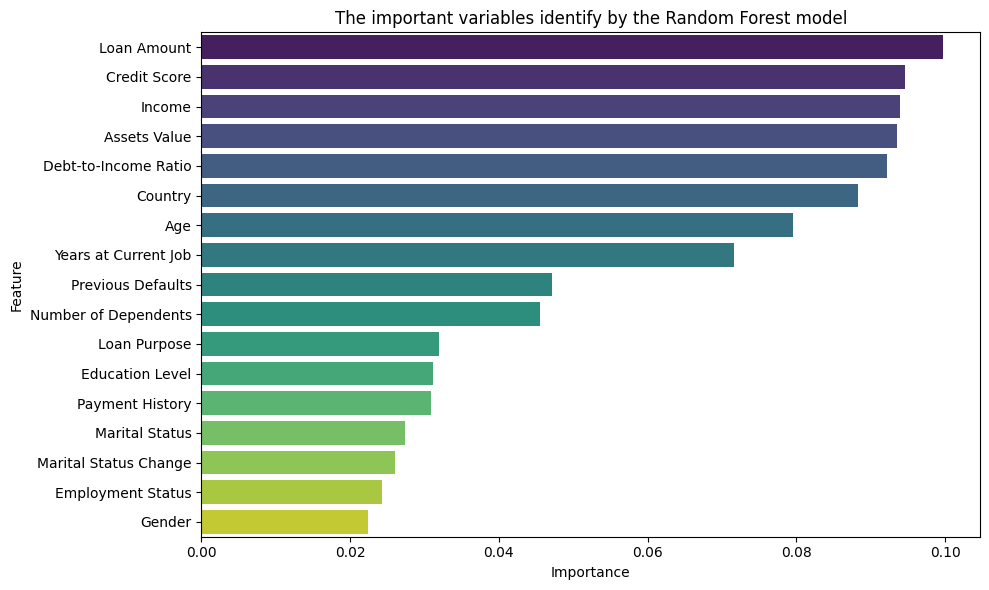

In [24]:
importances = model_rf.feature_importances_
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Importance', y='Feature', palette='viridis')
plt.title('The important variables identify by the Random Forest model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()